http://ned.ipac.caltech.edu/level5/March19/Baron/Baron2.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # statistical data visualization

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [2]:
# Using this to be able to plot spectra. For some reason Jupyter won't let me plot spectra without this
%matplotlib inline

## Create our own labels:
    - Random empty spot as noise
    
## Use entire spectrum and not encoded.

* Extracted entire noise spectrum. 

* Combine the high confidence and noise array. Here are the labels for it. 

### Ultimately, we want the ML algorithm to be able to pick out high-z sources from noise!

In [3]:
# loading in the decoded sources I got from inputting random encoded sources into t-sne.
# These will be our testing sample
random_highz_sources = np.load("highz_sources.npy")

In [4]:
# loading in my high confidence high z sources.
high_confidence_highz_spectra = np.load("high_confidence_highz_1000.npy", allow_pickle = True)

In [5]:
# loading in the noise sample.
noise_sample = np.load("noise_sample_1000.npy", allow_pickle = True)

In [35]:
noise_sample

array([[-0.27453507, -0.27376958, -0.27300397, ...,  0.05124273,
         0.05123827,  0.05123386],
       [ 0.107195  ,  0.10851217,  0.10982789, ...,  0.14232644,
         0.14230387,  0.14228151],
       [-0.06730778, -0.06700857, -0.06670939, ..., -0.06052472,
        -0.06053803, -0.06055122],
       ...,
       [-0.55389851, -0.55327332, -0.5526465 , ...,  0.04016945,
         0.04015587,  0.04014242],
       [ 0.19034464,  0.18940234,  0.18845793, ...,  0.48314523,
         0.48315916,  0.48317293],
       [ 1.20482559,  1.20504015,  1.2052516 , ...,  0.24669444,
         0.2467046 ,  0.24671464]])

In [6]:
df = pd.DataFrame(columns=[1, 2])
#df[1] = df[1].astype(object)
for i in range(1000):
    df.loc[i, 1] = noise_sample[i]
    df.loc[i, 2] = high_confidence_highz_spectra[i]
df

,1,2
0,"[-0.2745350651090622, -0.2737695754367118, -0....","[0.41081295627938086, 0.41056771447626034, 0.4..."
1,"[0.10719499983231176, 0.10851217425876615, 0.1...","[1.2038720574260438, 1.2035965089283491, 1.203..."
2,"[-0.06730778183374654, -0.06700857341262742, -...","[-0.3846966864195164, -0.383299771206096, -0.3..."
3,"[0.26524069710086234, 0.2641567780718815, 0.26...","[0.30983761383520153, 0.3103446243530814, 0.31..."
4,"[0.22173403554036744, 0.22058522042018333, 0.2...","[0.9560510273906166, 0.9591930732620303, 0.962..."
...,...,...
995,"[-0.9745579263840072, -0.9743290107782245, -0....","[0.03439495327132092, 0.03404298865517989, 0.0..."
996,"[0.651170647027954, 0.6509386707244421, 0.6507...","[0.026277668678197825, 0.02663091187239326, 0...."
997,"[-0.5538985072952052, -0.5532733222073725, -0....","[-0.3130105874134315, -0.31306856269327893, -0..."
998,"[0.19034463588101694, 0.1894023417498457, 0.18...","[1.001519775442492, 1.001469975314998, 1.00141..."


In [7]:
df.columns = ["noise", "confident-highz"]

In [8]:
df['confident-highz']

0      [0.41081295627938086, 0.41056771447626034, 0.4...
1      [1.2038720574260438, 1.2035965089283491, 1.203...
2      [-0.3846966864195164, -0.383299771206096, -0.3...
3      [0.30983761383520153, 0.3103446243530814, 0.31...
4      [0.9560510273906166, 0.9591930732620303, 0.962...
                             ...                        
995    [0.03439495327132092, 0.03404298865517989, 0.0...
996    [0.026277668678197825, 0.02663091187239326, 0....
997    [-0.3130105874134315, -0.31306856269327893, -0...
998    [1.001519775442492, 1.001469975314998, 1.00141...
999    [-0.17162231379271262, -0.1709112045033402, -0...
Name: confident-highz, Length: 1000, dtype: object

## Random-Forest classification

https://levelup.gitconnected.com/random-forest-regression-209c0f354c84#:~:text=Random%20Forest%20Regression%20is%20a%20supervised%20learning%20algorithm%20that%20uses,prediction%20than%20a%20single%20model.

https://www.datacamp.com/tutorial/random-forests-classifier-python

## According to internet, issues with overfitting! Possibly need more data.

https://stackoverflow.com/questions/62445343/randomforestregressor-in-sklearn-giving-negative-scores

In [9]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer

In [10]:
X = df['noise']

In [11]:
y= df['confident-highz']

In [31]:
kbins = KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')
noise_bin = kbins.fit_transform(noise_sample.reshape(-1,1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:209: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [32]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_bins(values):
    """visualizes the number of observations in each bin"""
    
    counter = Counter(values)
    plt.bar(counter.keys(), counter.values())
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.show() 

def show_bins(bins):
    """Shows the ranges of values the bins comprises"""
    
    for i in range(len(bins)-1):
        print(f'Bin {i}: {str(bins[i])} -> {str(bins[i+1])}')

In [33]:
noise_bin

array([[2.],
       [2.],
       [2.],
       ...,
       [6.],
       [6.],
       [6.]])

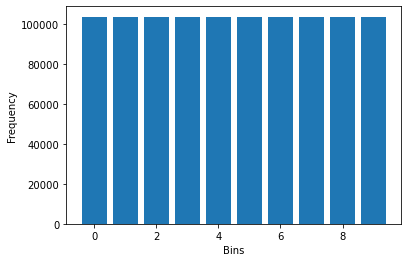

Bin 0: -210.52702673917548 -> -0.5532736962864887
Bin 1: -0.5532736962864887 -> -0.2956439361122232
Bin 2: -0.2956439361122232 -> -0.14532832866331538
Bin 3: -0.14532832866331538 -> -0.026835846421775732
Bin 4: -0.026835846421775732 -> 0.07573919613454325
Bin 5: 0.07573919613454325 -> 0.1883924669279068
Bin 6: 0.1883924669279068 -> 0.31919964235508774
Bin 7: 0.31919964235508774 -> 0.501722691907399
Bin 8: 0.501722691907399 -> 0.8672402521552904
Bin 9: 0.8672402521552904 -> 5430.736787879883


In [34]:
# show results
plot_bins(Counter(list(noise_bin.flatten())))
show_bins(kbins.bin_edges_[0])

### Make my own labels:
https://towardsdatascience.com/labeling-data-with-pandas-9e573ce59c42